<a href="https://colab.research.google.com/github/alvarofpinheiro/pifwia_fss/blob/main/PIFWIA_FSS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

FSS - Fish School Search ou Pesquisa de Cardumes de Peixes é uma metaheurística proposta pelos pesquisadores Fernando Buarque e Carmelo Filho em 2008 para resolver problemas de otimização inspirado no comportamento de cardumes, onde os mecanismos de alimentação e movimento coordenados dos peixes foram usados ​​como inspiração para criar os operadores de busca, tendo como ideia central a de fazer os peixes nadarem em direção ao gradiente positivo para se alimentar e ganhar peso, dessa forma os peixes mais pesados ​​têm mais influência no processo de busca como um todo, o que faz com que o baricentro do cardume se desloque para lugares melhores no espaço de busca ao longo das iterações, onde todos os peixes realizam buscas locais e o cardume agrega informações sociais.

Bastos-Filho, C.J.A.; Lima-Neto, F.B.; Lins, A.J.C.C.; Nascimento, A.I.S.; Lima, M.P. A novel search algorithm based on fish school behavior. IEEE Xplore. https://doi.org/10.1109/ICSMC.2008.4811695, 2008.

In [ ]:
#instala biblioteca Orange Canvas
!pip install Orange3

In [ ]:
#importa bibliotecas
import Orange
import random
import math
import matplotlib.pyplot as plt
from numpy.random import choice
from sklearn import metrics

In [ ]:
#define os hiperparâmetros
DIMENSOES = 2 #determina a quantidade de dimensões do problema
ITERACOES = 200 #quantiddade máxima de ciclos (episódios) especificando quantas explorações podem ser realizadas
CARDUME = 20 #tamanho da população correspondente ao número de peixes no aquário (tamanho do cardume)
E1 = -15 #extremo esquerdo eixo x
E2 = 15 #extremo direito eixo x
E3 = -100 #extremo inferior eixo y
E4 = 100 #extremo superior eixo y
LIMITES = [E3,E4] #(bound) determina os valores mínimos e máximos do espaço de busca
FCUSTO = 'rosenbrock' #(fitness) define a aptidão do peixe na possível solução do problema
PASSO_INICIAL = 0.01 #(swimming inicial) conduz os movimentos dos peixes
PASSO_FINAL = 0.000001 #(swimming final) conduz os movimentos dos peixes
PEIXES = [] #(swarm) array da criação dos peixes

In [ ]:
#importa dados
from google.colab import files  
files.upload()

In [ ]:
#instancia objeto de dados com base no caminho gerado na importação do arquivo
dados = Orange.data.Table("/content/dados.csv")

In [ ]:
#explora os metadados e dados da arquivo importado
qtde_campos = len(dados.domain.attributes)
qtde_cont = sum(1 for a in dados.domain.attributes if a.is_continuous)
qtde_disc = sum(1 for a in dados.domain.attributes if a.is_discrete)
print("%d metadados: %d continuos, %d discretos" % (qtde_campos, qtde_cont, qtde_disc))
print("Nome dos metadados:", ", ".join(dados.domain.attributes[i].name for i in range(qtde_campos)),)
dados.domain.attributes #explora dos domínios dos atributos (campos da base de dados)
print("Qtde de Registros:", len(dados)) #explora dos dados (quantidade de registros da base de dados)
i = 0 #exibe os primeiros registros para análise dos dados importados
for d in dados[:20]:
  i += 1
  print(i, d)

7 metadados: 7 continuos, 0 discretos
Nome dos metadados: PROCESSO, ANO, COMPLEXIDADE, PAGINA, PRAZO, REVISOES, ENTREGA
Qtde de Registros: 1013
1 [2022000101, 2019, 3, 12, 10, 4, 36]
2 [2022000102, 2020, 3, 20, 10, 4, 36]
3 [2022000103, 2020, 3, 55, 15, 5, 70]
4 [2022000104, 2018, 4, 43, 10, 4, 36]
5 [2022000105, 2018, 2, 24, 10, 4, 36]
6 [2022000106, 2019, 1, 93, 15, 3, 42]
7 [2022000107, 2018, 3, 44, 10, 5, 45]
8 [2022000108, 2020, 2, 37, 10, 5, 45]
9 [2022000109, 2020, 1, 11, 10, 2, 18]
10 [2022000110, 2019, 1, 10, 5, 2, 8]
11 [2022000111, 2020, 2, 32, 10, 5, 45]
12 [2022000112, 2019, 2, 13, 10, 3, 27]
13 [2022000113, 2020, 1, 14, 10, 2, 18]
14 [2022000114, 2020, 3, 51, 15, 1, 14]
15 [2022000115, 2019, 4, 8, 5, 1, 4]
16 [2022000116, 2020, 3, 82, 15, 2, 28]
17 [2022000117, 2020, 2, 12, 10, 3, 27]
18 [2022000118, 2018, 2, 16, 10, 2, 18]
19 [2022000119, 2018, 2, 97, 15, 5, 70]
20 [2022000120, 2018, 4, 87, 15, 5, 70]


In [ ]:
#cria arrays das dimensões do problema a ser otimizado
periodo = []
complexidade = [] #1-muito baixa complexidade;2-baixa complexidade;3-média complexidade;4-alta complexidade;e,5-muito alta complexidade
pagina = []
prazo = []
revisao = []
entrega = []
i = 0
for d in dados[:CARDUME]:
  periodo.append(d[1])
  complexidade.append(d[2])
  pagina.append(d[3])
  prazo.append(d[4])
  revisao.append(d[5])
  entrega.append(d[6])
  print("id:",i,"período:",periodo[i],"complexidade:",complexidade[i],"página:",pagina[i],"prazo:",prazo[i],"revisões:",revisao[i],"entrega:",entrega[i])
  i += 1

id: 0 período: 2019 complexidade: 3 página: 12 prazo: 10 revisões: 4 entrega: 36
id: 1 período: 2020 complexidade: 3 página: 20 prazo: 10 revisões: 4 entrega: 36
id: 2 período: 2020 complexidade: 3 página: 55 prazo: 15 revisões: 5 entrega: 70
id: 3 período: 2018 complexidade: 4 página: 43 prazo: 10 revisões: 4 entrega: 36
id: 4 período: 2018 complexidade: 2 página: 24 prazo: 10 revisões: 4 entrega: 36
id: 5 período: 2019 complexidade: 1 página: 93 prazo: 15 revisões: 3 entrega: 42
id: 6 período: 2018 complexidade: 3 página: 44 prazo: 10 revisões: 5 entrega: 45
id: 7 período: 2020 complexidade: 2 página: 37 prazo: 10 revisões: 5 entrega: 45
id: 8 período: 2020 complexidade: 1 página: 11 prazo: 10 revisões: 2 entrega: 18
id: 9 período: 2019 complexidade: 1 página: 10 prazo: 5 revisões: 2 entrega: 8
id: 10 período: 2020 complexidade: 2 página: 32 prazo: 10 revisões: 5 entrega: 45
id: 11 período: 2019 complexidade: 2 página: 13 prazo: 10 revisões: 3 entrega: 27
id: 12 período: 2020 complex

In [ ]:
#função custo ou objetivo ou aptidão ou otimização ou fitness - usada para buscar o melhor ponto dentro de um espaço de buscao (melhor global) sem ficar preso em um melhor local
def fcusto(problema, possivel_solucao, alfa=0, beta=0, gama=0, delta=0, epsilon=0, zeta=0):
  total = 0.0
  if problema == 'rosenbrock':
    for i in range(DIMENSOES-1):
      total += 100*(possivel_solucao[i+1] - possivel_solucao[i]**2)**2 + (1-possivel_solucao[i])**2
  elif problema == 'esfera':
    for i in range(DIMENSOES):
      total += possivel_solucao[i]**2
  elif problema == 'custo':
    for i in range(DIMENSOES-1):
      total += 1 / abs(sum([coord ** 2 for coord in possivel_solucao]))
  elif problema == 'caminho':
    denominador = sum([(caminho.feromonio)**alfa * (1 / caminho.comprimento)**beta for caminho in possivel_solucao])
    distribuicao_probabilidades = None
    if denominador == 0:
      distribuicao_probabilidades = [1 / len(possivel_solucao)  for _ in possivel_solucao]
    else:
      distribuicao_probabilidades = [((caminho.feromonio)**alfa * (1 / caminho.comprimento)**beta) / denominador for caminho in possivel_solucao]
    total = choice(possivel_solucao, 1, p=distribuicao_probabilidades)[0]
  elif problema == "distância":
    total = 0
    pontos = []
    for i in range(CARDUME): 
      if i < CARDUME - 1:
        total += pontos[possivel_solucao[i]].distancia(pontos[possivel_solucao[i+1]])
      else:
        total += pontos[possivel_solucao[i]].distancia(pontos[possivel_solucao[0]])
    total = 1/total
  else:
    print('Problema não encontrado!')
  return total

In [ ]:
#peixe - unidade base da otimização, posicionado numa determinada posição no espaço de busca do problema, representando uma possível solução para o problema
class Peixe:
  def __init__(self):
    self.posicao = [0.0] * DIMENSOES
    self.fitness = 0.0
    self.dif_distancia = [0.0] * DIMENSOES
    self.dif_fitness = 0.0
    self.peso = 1.0

In [ ]:
#calcula movimento individual - cada peixe escolhe aleatoriamente uma nova posição em sua vizinhança e a avalia com a função aptidão ou objetivo (fitness)
def movimento_individual(populacao, passo_atual, problema):
  for peixe in populacao:
    nova_posicao = []
    novo_fitness = 0.0
    for dimensao in range(DIMENSOES):
      #calcula a nova posicao
      direcao = random.random()*2 - 1
      mudanca = direcao*passo_atual*(LIMITES[1] - LIMITES[0])
      nova_posicao.append(peixe.posicao[dimensao] + mudanca)
      #verifica se ultrapassa os limites superior e inferior
      if nova_posicao[-1] > LIMITES[1]:
        nova_posicao[-1] = LIMITES[1]
      elif nova_posicao[-1] < LIMITES[0]:
        nova_posicao[-1] = LIMITES[0]         
    #verifica o fitness da nova posicao
    novo_fitness = fcusto(problema, nova_posicao)
    #o peixe escolhe a melhor posicao e salva a diferenca de fitness e de posicao
    if(novo_fitness < peixe.fitness):
      peixe.dif_fitness = peixe.fitness - novo_fitness
      peixe.fitness = novo_fitness
      for dim in range(DIMENSOES):
        peixe.dif_distancia[dim] = nova_posicao[dim] - peixe.posicao[dim]
        peixe.posicao[dim] = nova_posicao[dim]
    else:
      peixe.dif_fitness = 0
      for dim in range(DIMENSOES):
        peixe.dif_distancia[dim] = 0

In [ ]:
#calcula movimento instintivo - somente peixes que realizaram movimentos individuais com sucesso poderão determinar a direção do movimento do cardume (swimming)
def movimento_instintivo(populacao):
  total_diferenca_fitness = 0.0
  vetor_i = [0.0] * DIMENSOES
  for peixe in populacao:
    total_diferenca_fitness += peixe.dif_fitness
    for i in range(DIMENSOES):
      vetor_i[i] += peixe.dif_distancia[i]*peixe.dif_fitness
  if total_diferenca_fitness != 0:
    for i in range(DIMENSOES):
      vetor_i[i] /= total_diferenca_fitness
    for peixe in populacao:
      for i in range(DIMENSOES):
        peixe.posicao[i] += vetor_i[i]
        #verifica se ultrapassa os limites superior e inferior
        if peixe.posicao[i] > LIMITES[1]:
          peixe.posicao[i] = LIMITES[1]
        elif peixe.posicao[i] < LIMITES[0]:
          peixe.posicao[i] = LIMITES[0]

In [ ]:
#calcula movimento volitivo - poder de escolha baseado na taxa geral de sucesso do cardume (swimming)
def movimento_volitivo(populacao, baricentro, mudanca_peso, passo):
  for peixe in populacao:
    for i in range(DIMENSOES):
      direcao = random.random()
      if mudanca_peso < 0:
        peixe.posicao[i] -= 2*passo*direcao*(LIMITES[1] - LIMITES[0])* ((peixe.posicao[i] - baricentro[i])/distancia(peixe.posicao, baricentro))
      else:
        peixe.posicao[i] += 2*passo*direcao*(LIMITES[1] - LIMITES[0])* ((peixe.posicao[i] - baricentro[i])/distancia(peixe.posicao, baricentro))
      #verifica se ultrapassa os limites superior e inferior
      if peixe.posicao[i] > LIMITES[1]:
        peixe.posicao[i] = LIMITES[1]
      elif peixe.posicao[i] < LIMITES[0]:
        peixe.posicao[i] = LIMITES[0]

In [ ]:
#calcula operação de alimentação - cada peixe pode aumentar seu peso dependendo da taxa de sucesso obtida pelo movimento indiviaul (feeding)
def alimentacao(populacao):
  maior_diferenca_fitness = 0
  mudanca_peso = 0
  for peixe in populacao:
    mudanca_peso += peixe.peso
    if peixe.dif_fitness > maior_diferenca_fitness:
      maior_diferenca_fitness = peixe.dif_fitness
  if maior_diferenca_fitness != 0:
    for peixe in populacao:
      peixe.peso += peixe.dif_fitness/maior_diferenca_fitness
      mudanca_peso -= peixe.peso
    return mudanca_peso
  else:
    return 0

In [ ]:
#calcula baricentro - ponto de aplicação da força de gravidade de acordo com a força-peso (memória do cardume)
def calcular_baricentro(populacao):
  baricentro = [0.0] * DIMENSOES
  peso_total = 0.0
  for peixe in populacao:
    peso_total += peixe.peso
    for i in range(DIMENSOES):
      baricentro[i] += peixe.peso * peixe.posicao[i]
  for i in range(DIMENSOES):
    baricentro[i] /= peso_total
  return baricentro

In [ ]:
#calcula distância
def distancia(lista_1, lista_2):
  dist = 0.0
  for i in range(len(lista_1)):
    dist += (lista_1[i] - lista_2[i])**2
  return math.sqrt(dist)

In [ ]:
#calcula atualização do passo (conduz os movimentos dos peixes)
def atualizar_passo(passo):
    return passo - ((PASSO_INICIAL - PASSO_FINAL) / ITERACOES)

In [ ]:
#plota posições no gráfico
def exibe_grafico(titulo,x,y):
  plt.axis([E1,E2,E3,E4])
  plt.plot(0,0, marker='*', markersize=10, color='b')
  plt.title(titulo)
  for i in range(CARDUME):
    plt.plot(x[i],y[i],marker='o')
  plt.show()

In [ ]:
#inicializa população (cardume)
PEIXES = []
for i in range(CARDUME):
  cpx = complexidade[i]
  pag = pagina[i]
  PEIXES.append(Peixe())
  posicoes = []
  for j in range(DIMENSOES):
    if (j == 0):
      posicao = cpx
    elif (j == 1):
      posicao = pag
    else:
      print('Dimensão não encontrado!')
    posicoes.append(posicao)
  PEIXES[-1].posicao = posicoes
  PEIXES[-1].fitness = fcusto(FCUSTO, PEIXES[-1].posicao)
for i in range(CARDUME):
  print("i:",i,"posição:",list(PEIXES[i].posicao),"otimização:",PEIXES[i].fitness)

i: 0 posição: [Value('COMPLEXIDADE', 3), Value('PAGINA', 12)] otimização: 904.0
i: 1 posição: [Value('COMPLEXIDADE', 3), Value('PAGINA', 20)] otimização: 12104.0
i: 2 posição: [Value('COMPLEXIDADE', 3), Value('PAGINA', 55)] otimização: 211604.0
i: 3 posição: [Value('COMPLEXIDADE', 4), Value('PAGINA', 43)] otimização: 72909.0
i: 4 posição: [Value('COMPLEXIDADE', 2), Value('PAGINA', 24)] otimização: 40001.0
i: 5 posição: [Value('COMPLEXIDADE', 1), Value('PAGINA', 93)] otimização: 846400.0
i: 6 posição: [Value('COMPLEXIDADE', 3), Value('PAGINA', 44)] otimização: 122504.0
i: 7 posição: [Value('COMPLEXIDADE', 2), Value('PAGINA', 37)] otimização: 108901.0
i: 8 posição: [Value('COMPLEXIDADE', 1), Value('PAGINA', 11)] otimização: 10000.0
i: 9 posição: [Value('COMPLEXIDADE', 1), Value('PAGINA', 10)] otimização: 8100.0
i: 10 posição: [Value('COMPLEXIDADE', 2), Value('PAGINA', 32)] otimização: 78401.0
i: 11 posição: [Value('COMPLEXIDADE', 2), Value('PAGINA', 13)] otimização: 8101.0
i: 12 posição:

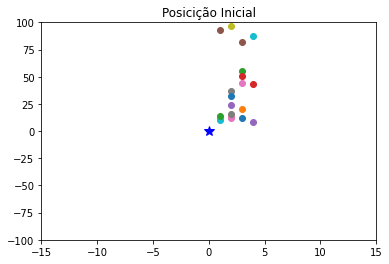

In [ ]:
#posiciona os peixes no espaço de busca (aquário)
x = []
y = []
for i in range(CARDUME):
  peixe = PEIXES[i]
  d1,d2 = zip(peixe.posicao)
  x.append(d1)
  y.append(d2)
exibe_grafico('Posicição Inicial',x,y)

Iteração: 1


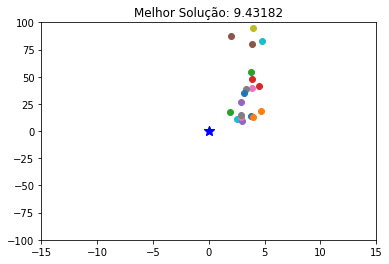

Iteração: 2


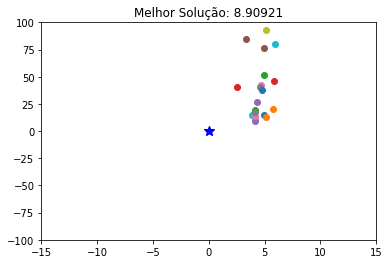

Iteração: 3


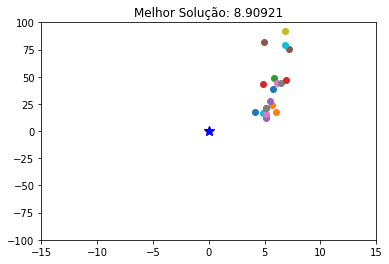

Iteração: 4


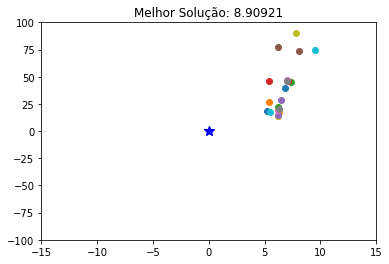

Iteração: 5


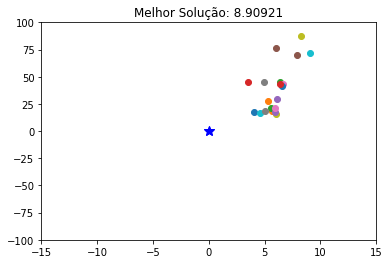

Iteração: 6


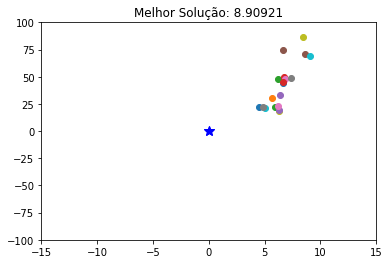

Iteração: 7


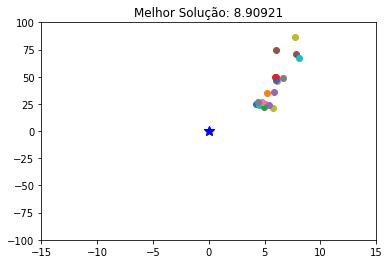

Iteração: 8


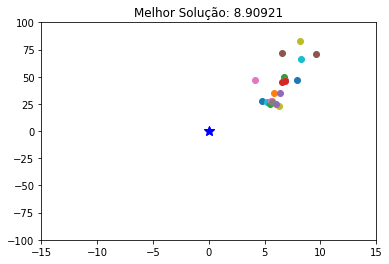

Iteração: 9


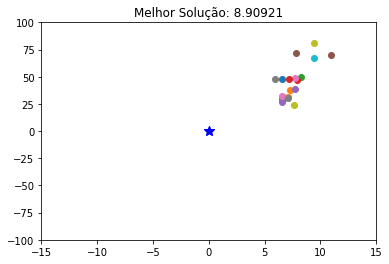

Iteração: 10


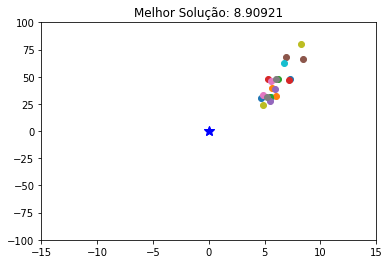

Iteração: 11


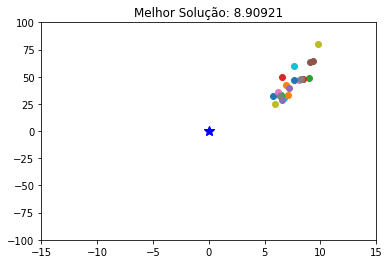

Iteração: 12


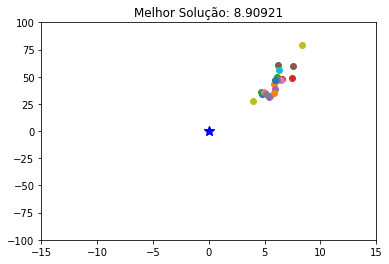

Iteração: 13


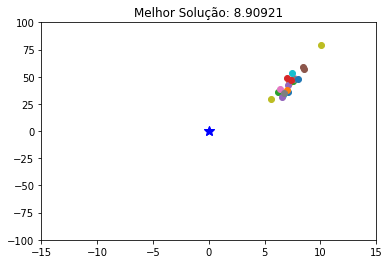

Iteração: 14


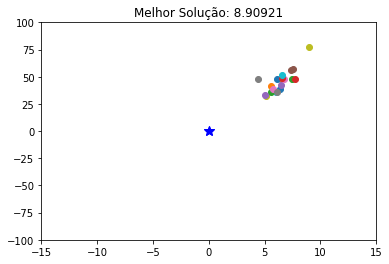

Iteração: 15


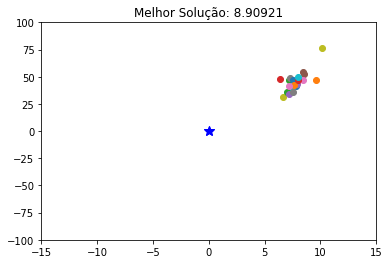

Iteração: 16


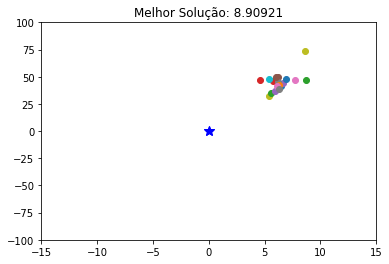

Iteração: 17


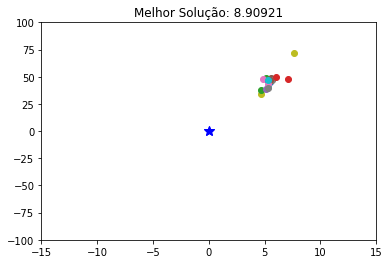

Iteração: 18


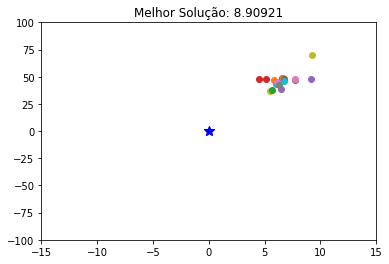

Iteração: 19


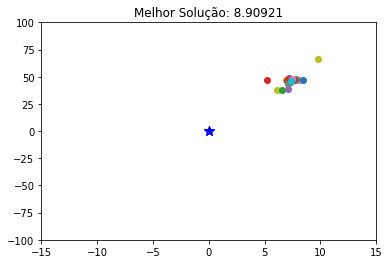

Iteração: 20


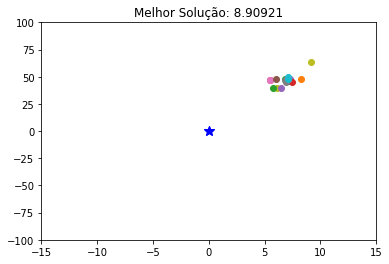

Iteração: 21


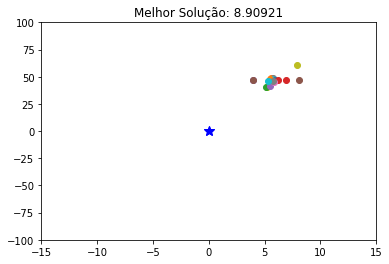

Iteração: 22


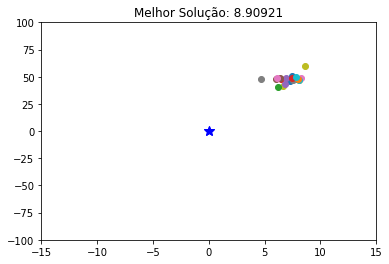

Iteração: 23


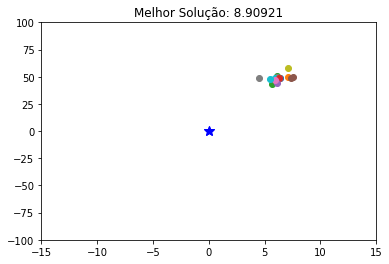

Iteração: 24


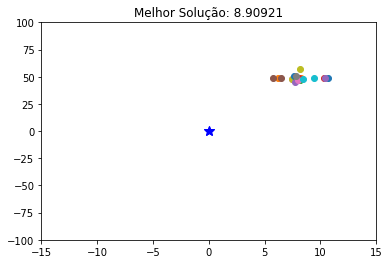

Iteração: 25


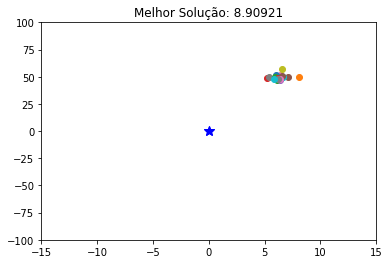

Iteração: 26


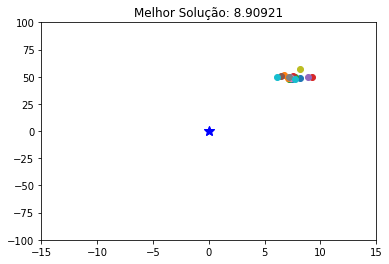

Iteração: 27


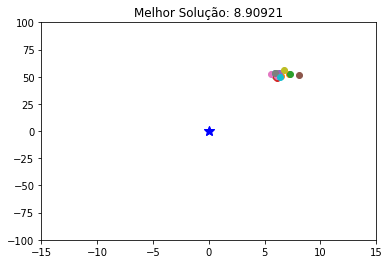

Iteração: 28


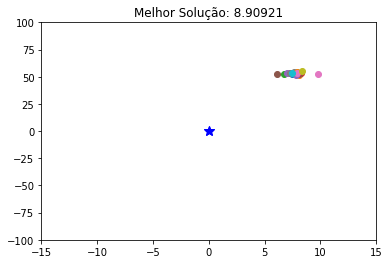

Iteração: 29


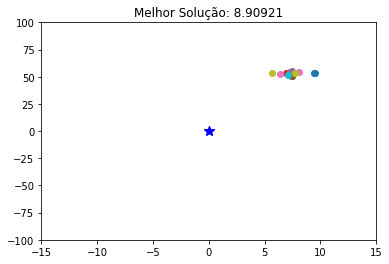

Iteração: 30


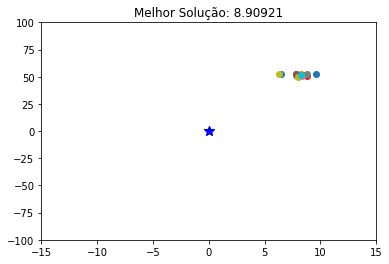

Iteração: 31


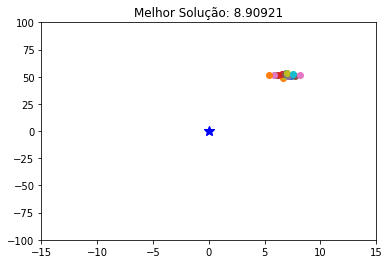

Iteração: 32


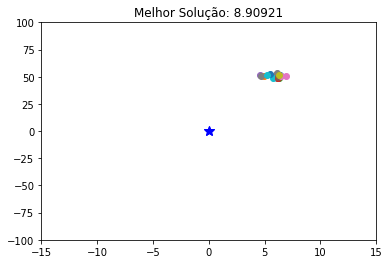

Iteração: 33


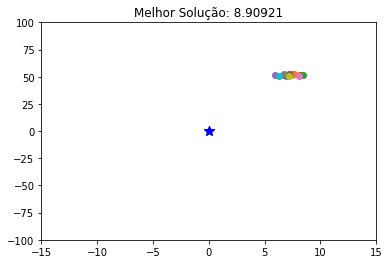

Iteração: 34


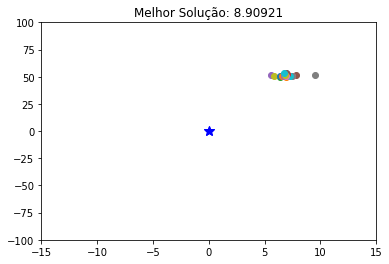

Iteração: 35


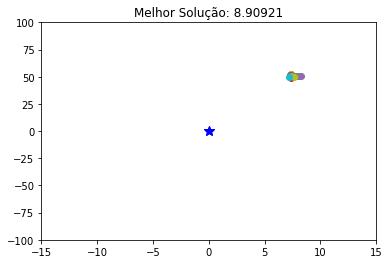

Iteração: 36


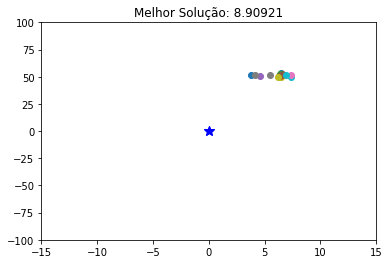

Iteração: 37


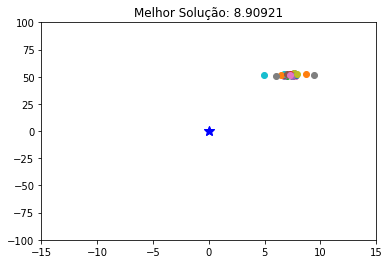

Iteração: 38


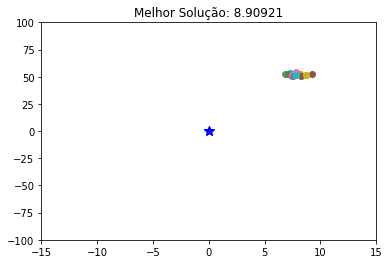

Iteração: 39


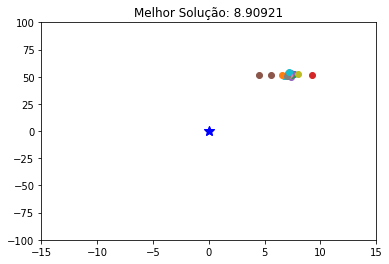

Iteração: 40


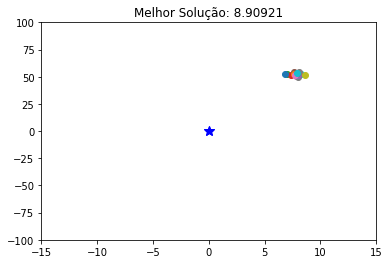

Iteração: 41


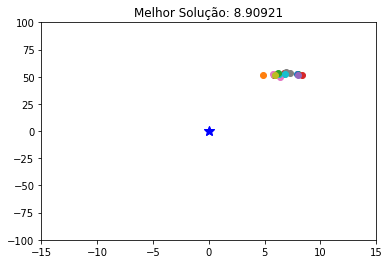

Iteração: 42


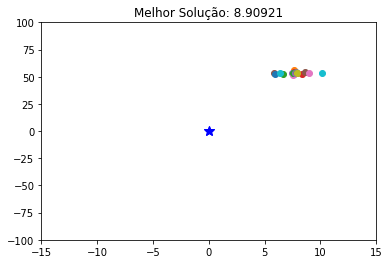

Iteração: 43


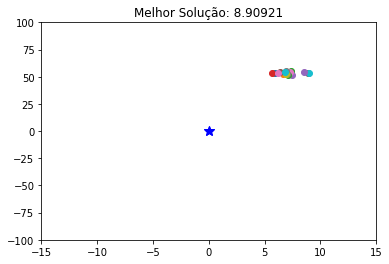

Iteração: 44


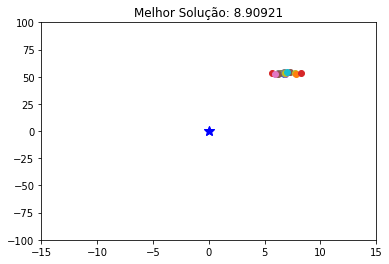

Iteração: 45


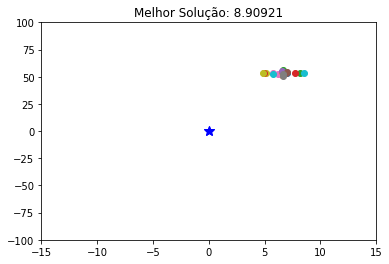

Iteração: 46


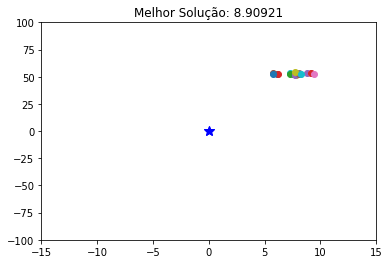

Iteração: 47


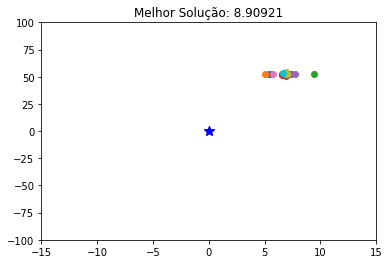

Iteração: 48


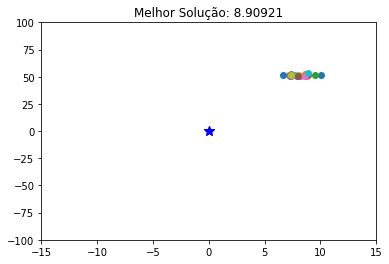

Iteração: 49


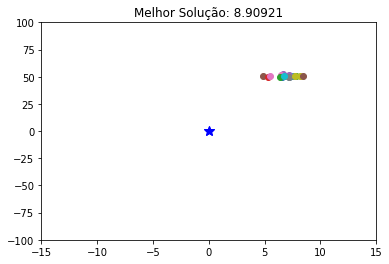

Iteração: 50


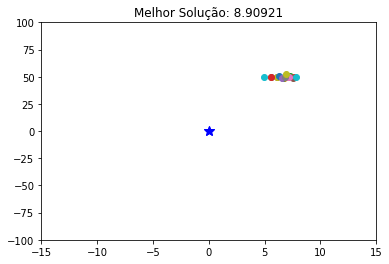

Iteração: 51


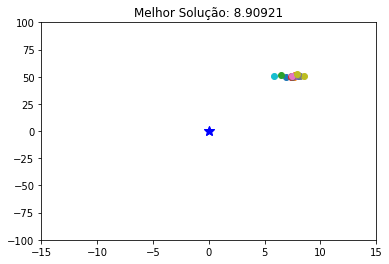

Iteração: 52


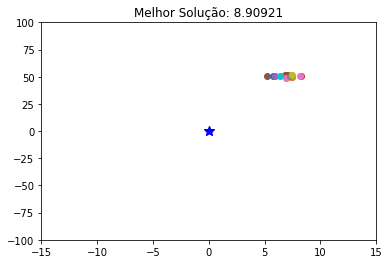

Iteração: 53


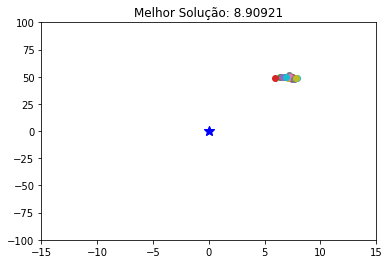

Iteração: 54


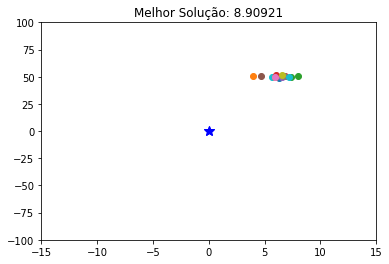

Iteração: 55


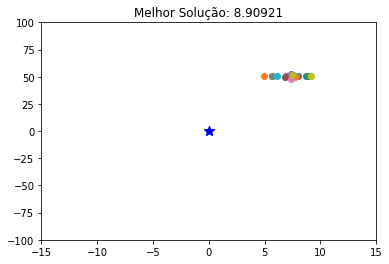

Iteração: 56


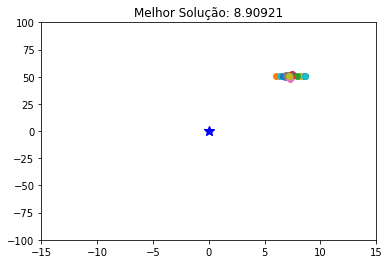

Iteração: 57


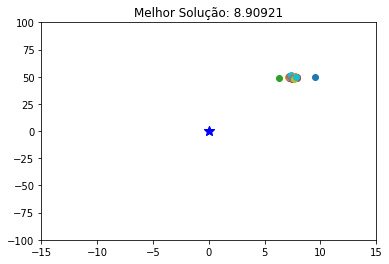

Iteração: 58


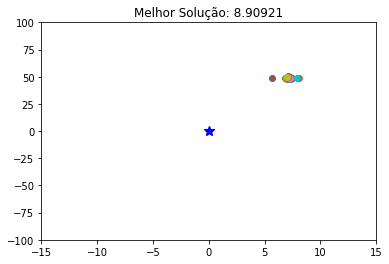

Iteração: 59


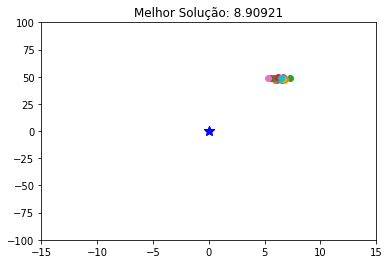

Iteração: 60


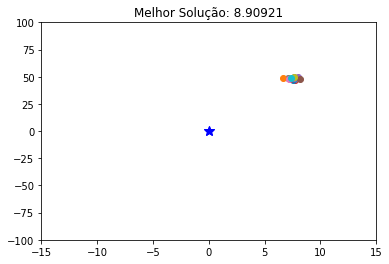

Iteração: 61


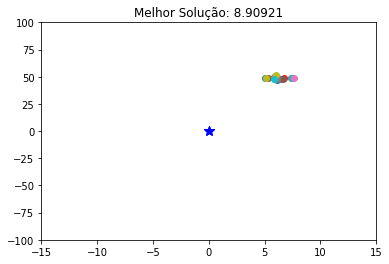

Iteração: 62


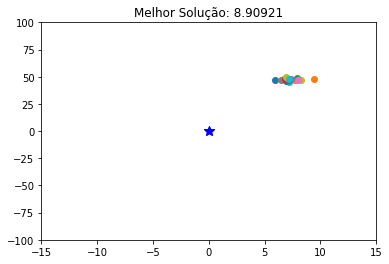

Iteração: 63


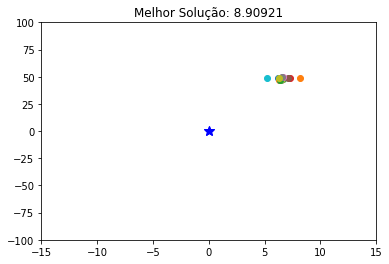

Iteração: 64


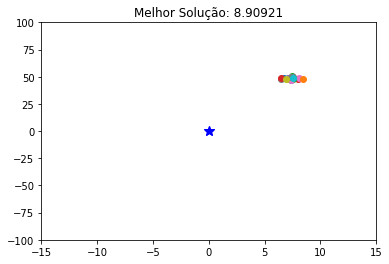

Iteração: 65


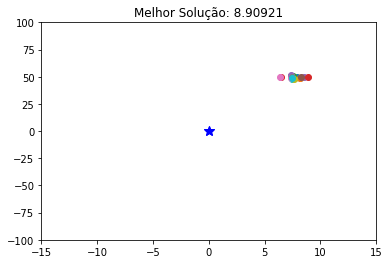

Iteração: 66


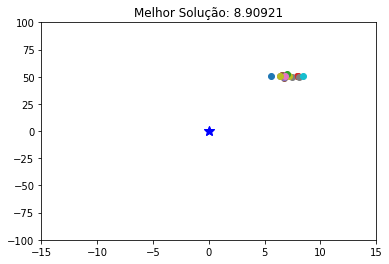

Iteração: 67


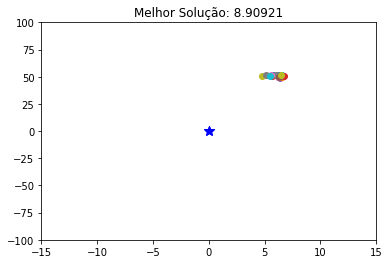

Iteração: 68


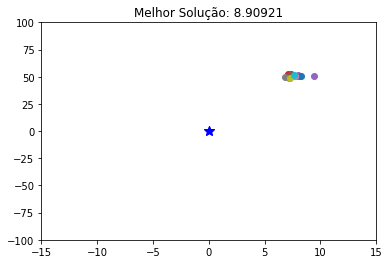

Iteração: 69


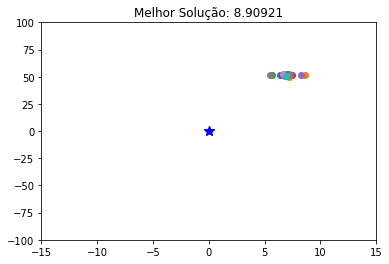

Iteração: 70


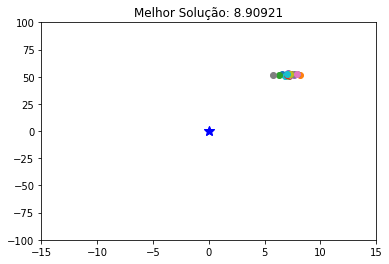

Iteração: 71


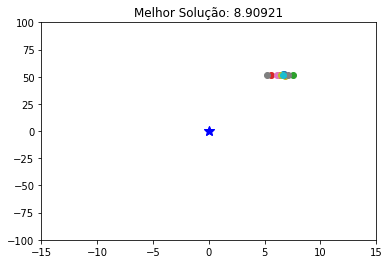

Iteração: 72


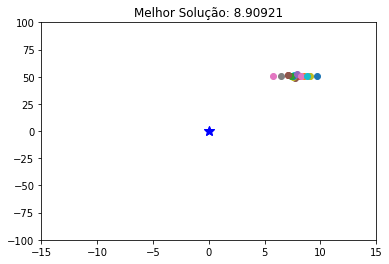

Iteração: 73


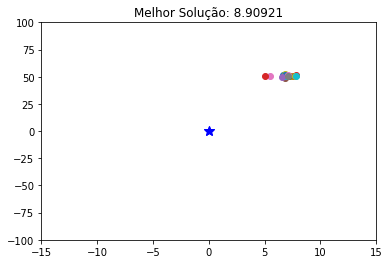

Iteração: 74


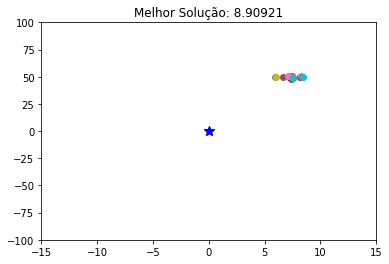

Iteração: 75


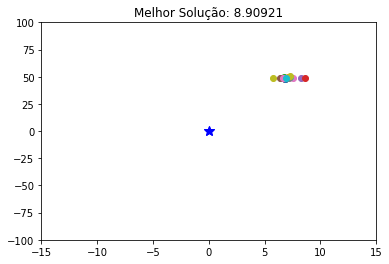

Iteração: 76


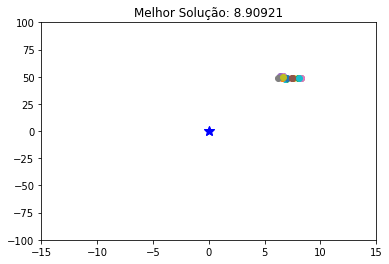

Iteração: 77


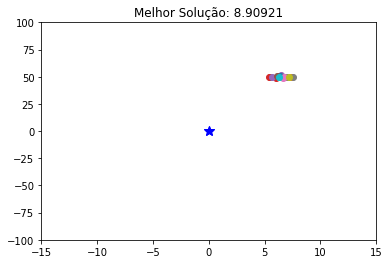

Iteração: 78


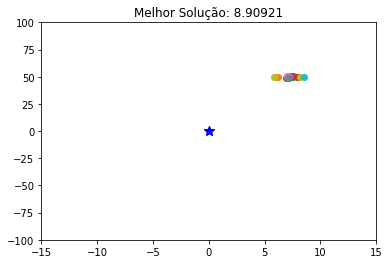

Iteração: 79


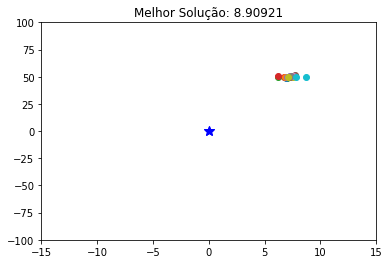

Iteração: 80


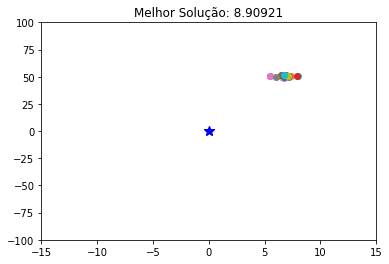

Iteração: 81


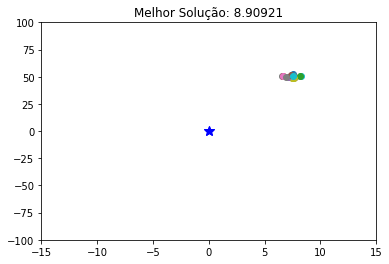

Iteração: 82


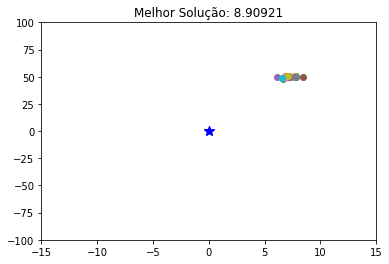

Iteração: 83


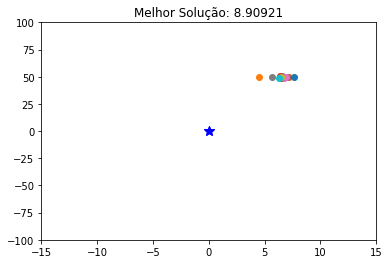

Iteração: 84


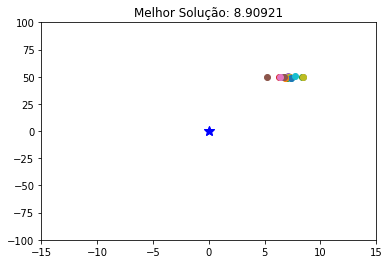

Iteração: 85


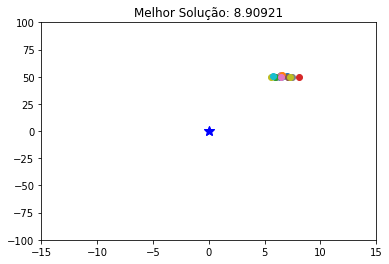

Iteração: 86


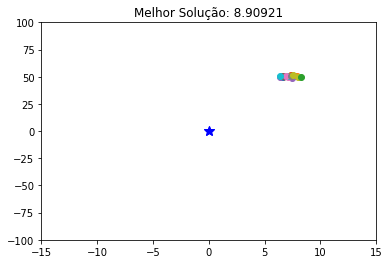

Iteração: 87


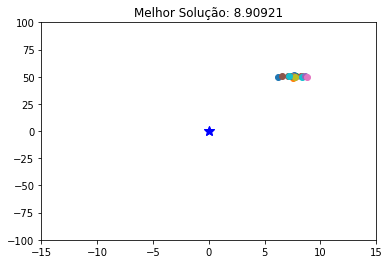

Iteração: 88


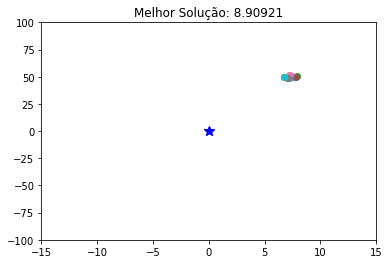

Iteração: 89


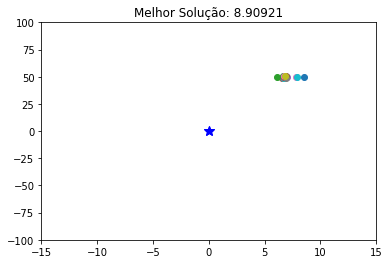

Iteração: 90


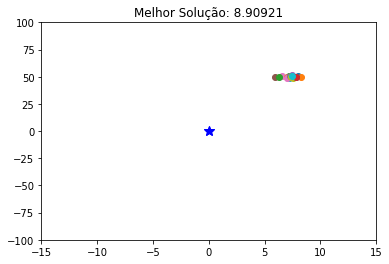

Iteração: 91


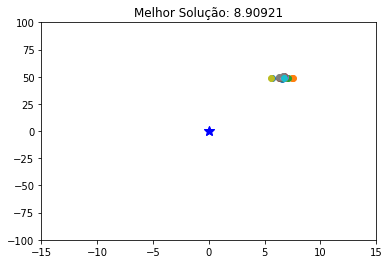

Iteração: 92


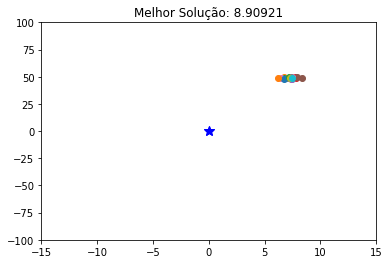

Iteração: 93


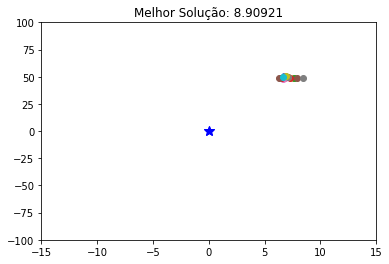

Iteração: 94


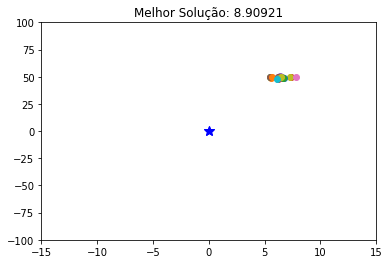

Iteração: 95


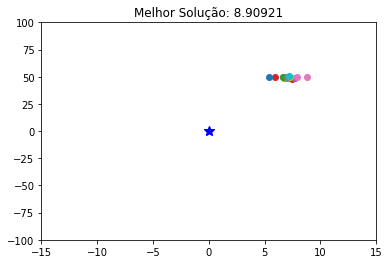

Iteração: 96


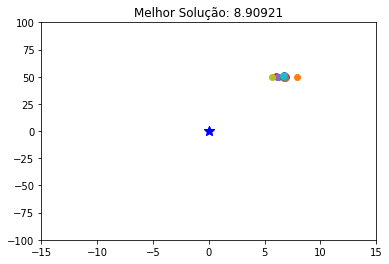

Iteração: 97


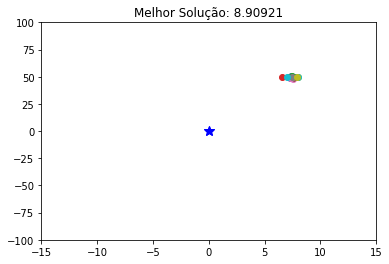

Iteração: 98


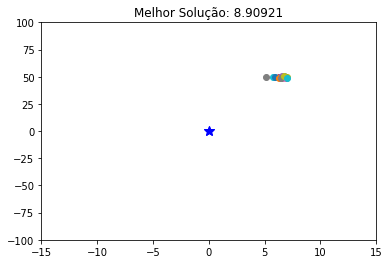

Iteração: 99


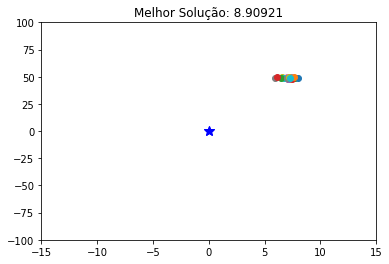

Iteração: 100


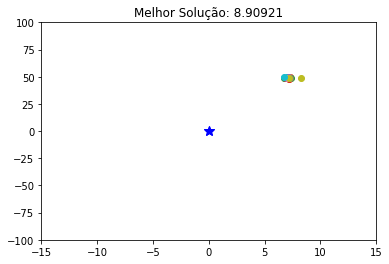

Iteração: 101


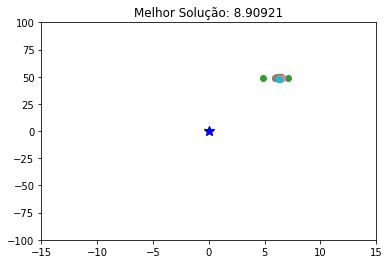

Iteração: 102


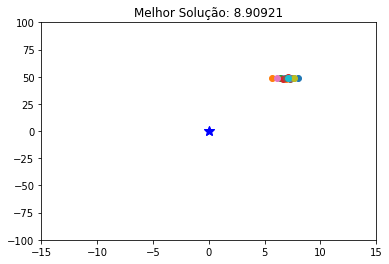

Iteração: 103


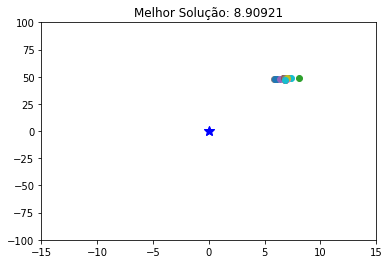

Iteração: 104


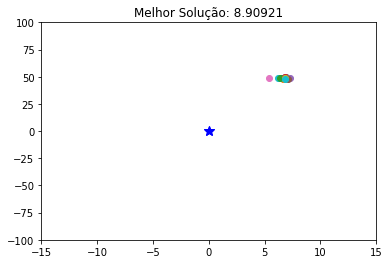

Iteração: 105


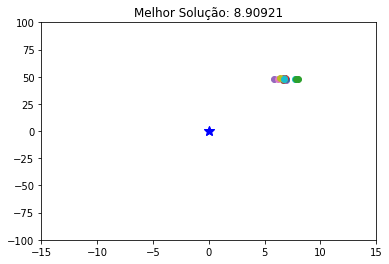

Iteração: 106


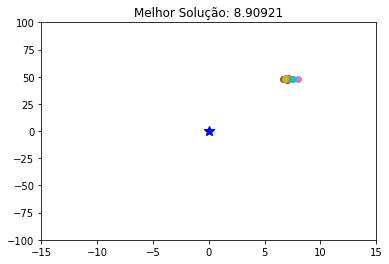

Iteração: 107


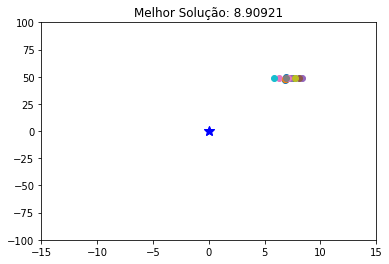

Iteração: 108


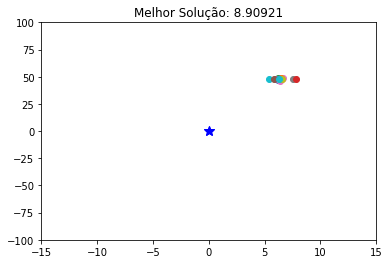

Iteração: 109


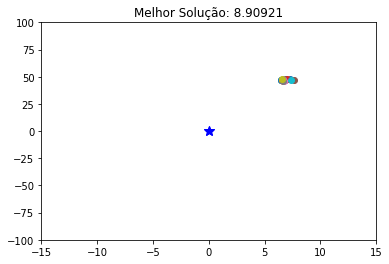

Iteração: 110


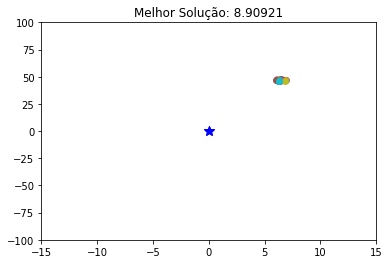

Iteração: 111


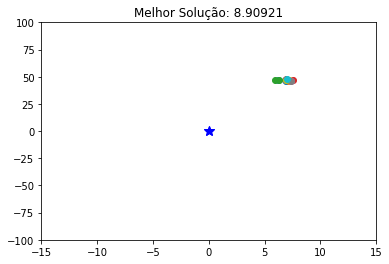

Iteração: 112


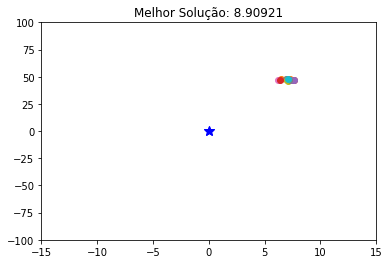

Iteração: 113


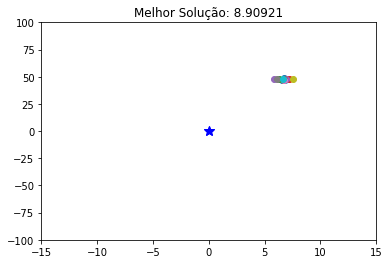

Iteração: 114


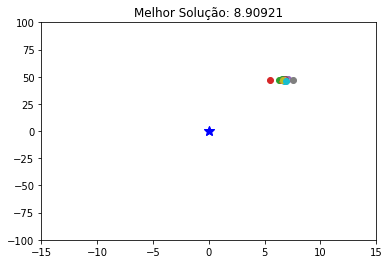

Iteração: 115


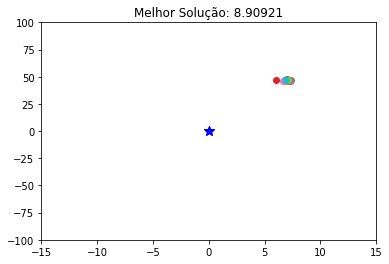

Iteração: 116


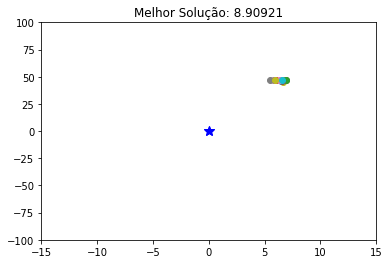

Iteração: 117


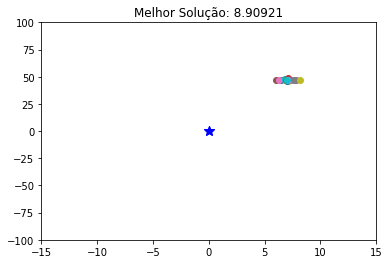

Iteração: 118


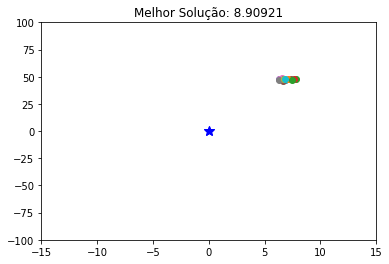

Iteração: 119


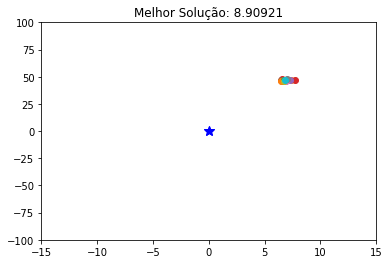

Iteração: 120


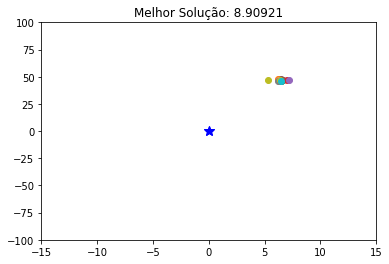

Iteração: 121


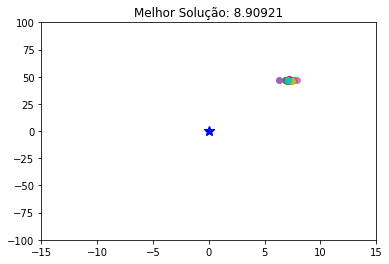

Iteração: 122


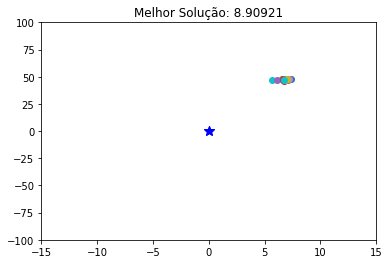

Iteração: 123


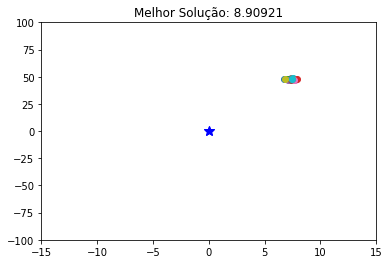

Iteração: 124


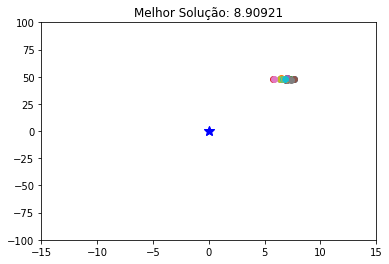

Iteração: 125


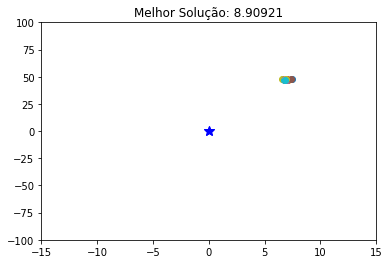

Iteração: 126


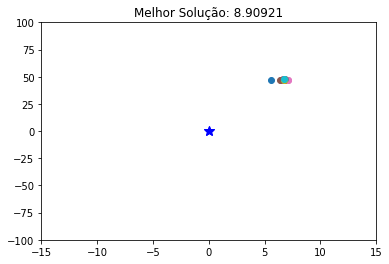

Iteração: 127


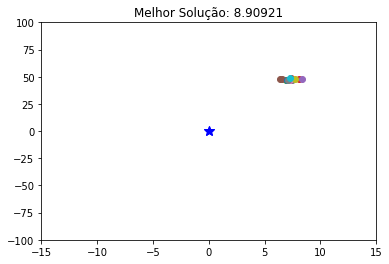

Iteração: 128


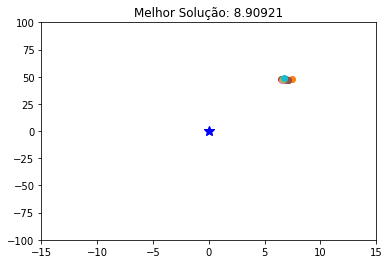

Iteração: 129


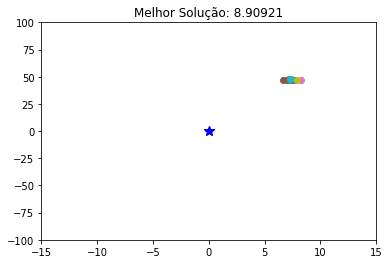

Iteração: 130


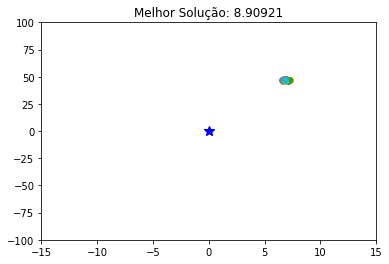

Iteração: 131


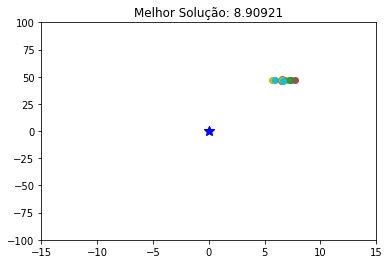

Iteração: 132


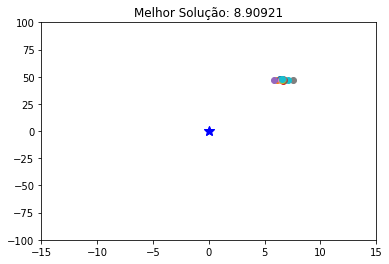

Iteração: 133


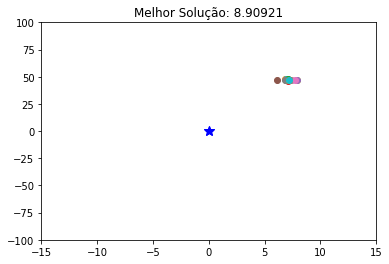

Iteração: 134


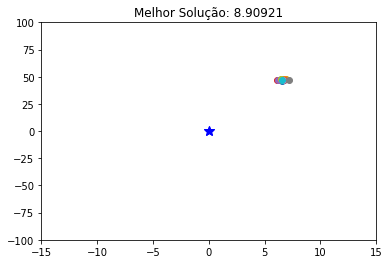

Iteração: 135


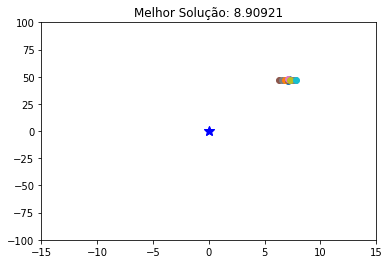

Iteração: 136


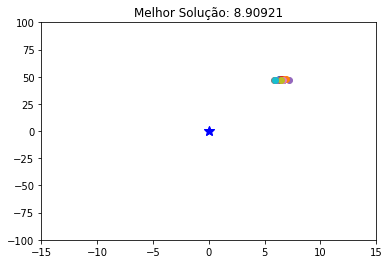

Iteração: 137


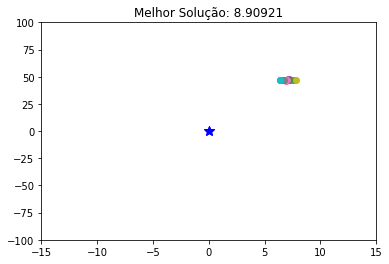

Iteração: 138


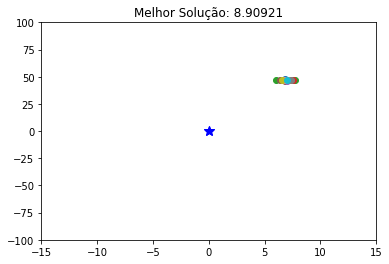

Iteração: 139


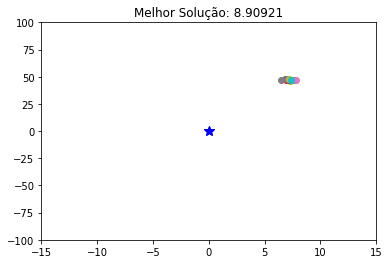

Iteração: 140


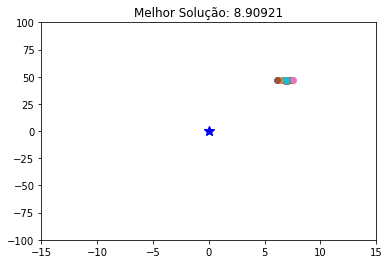

Iteração: 141


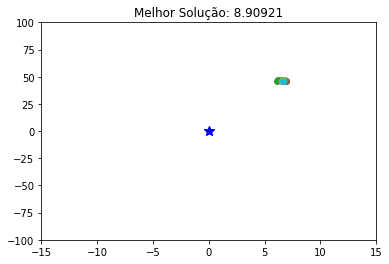

Iteração: 142


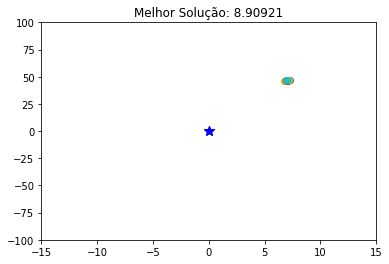

Iteração: 143


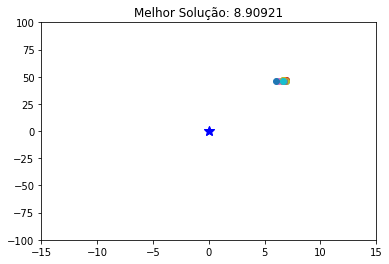

Iteração: 144


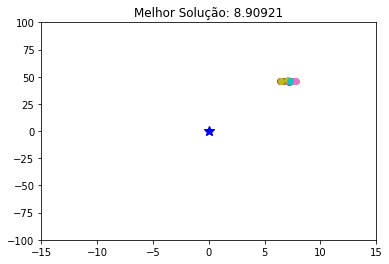

Iteração: 145


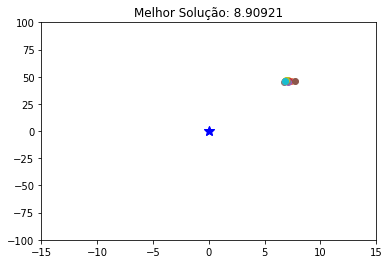

Iteração: 146


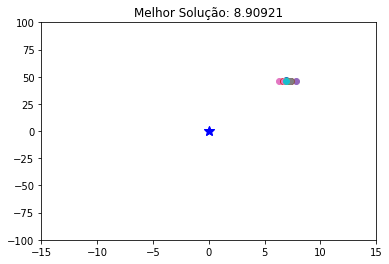

Iteração: 147


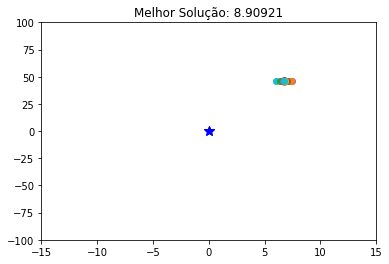

Iteração: 148


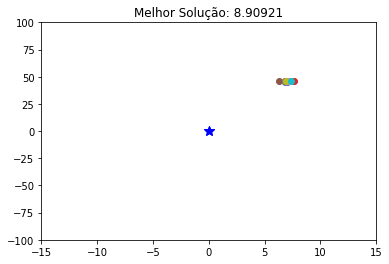

Iteração: 149


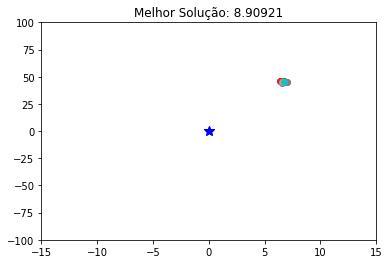

Iteração: 150


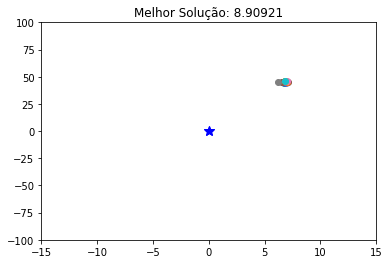

Iteração: 151


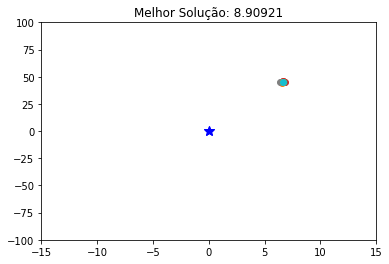

Iteração: 152


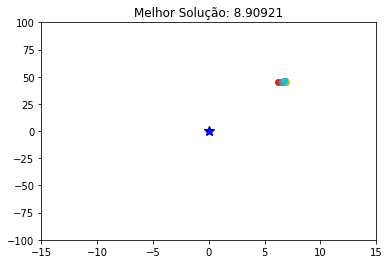

Iteração: 153


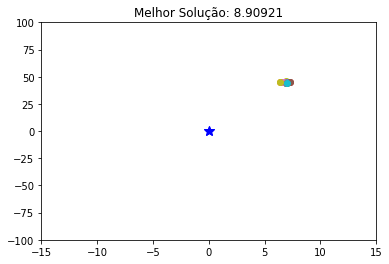

Iteração: 154


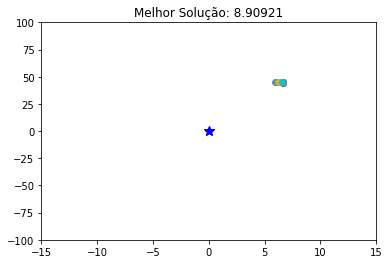

Iteração: 155


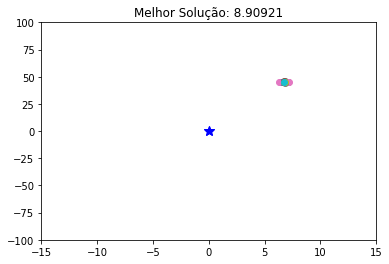

Iteração: 156


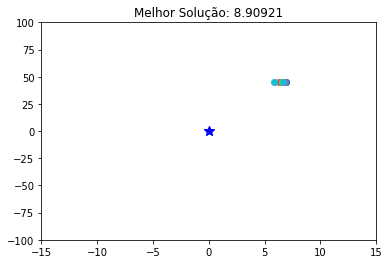

Iteração: 157


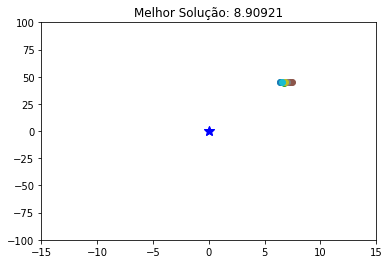

Iteração: 158


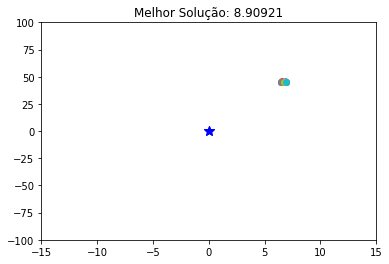

Iteração: 159


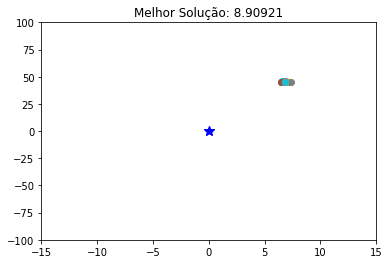

Iteração: 160


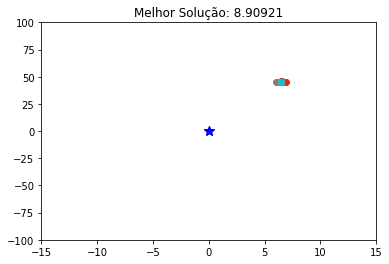

Iteração: 161


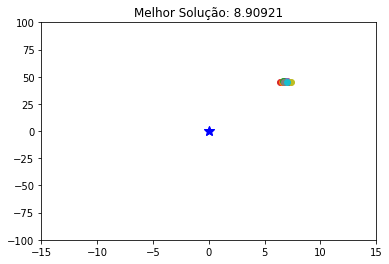

Iteração: 162


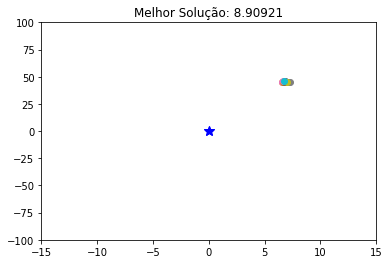

Iteração: 163


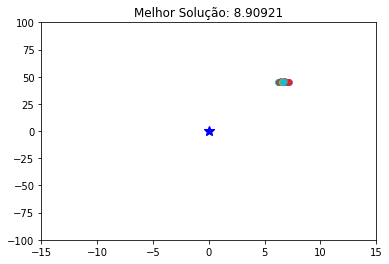

Iteração: 164


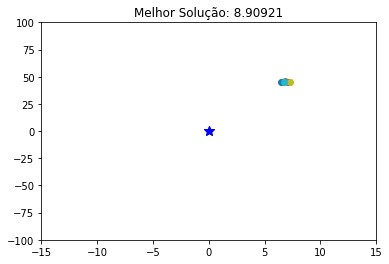

Iteração: 165


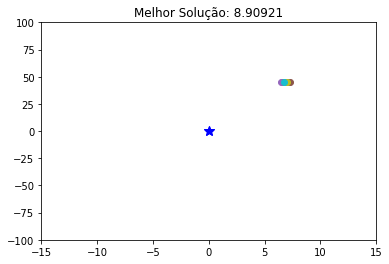

Iteração: 166


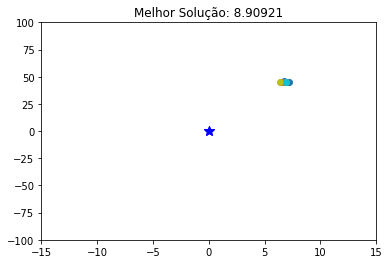

Iteração: 167


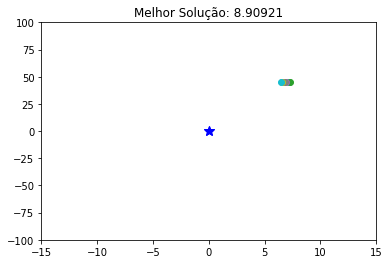

Iteração: 168


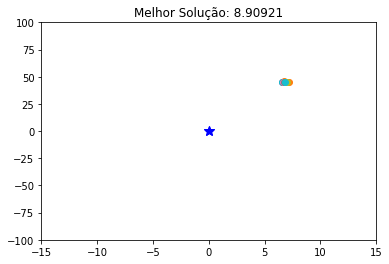

Iteração: 169


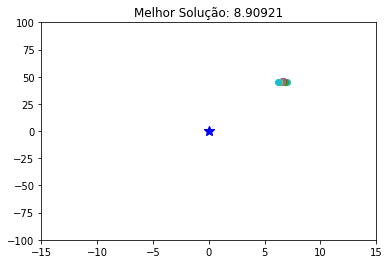

Iteração: 170


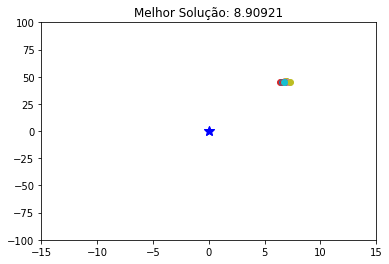

Iteração: 171


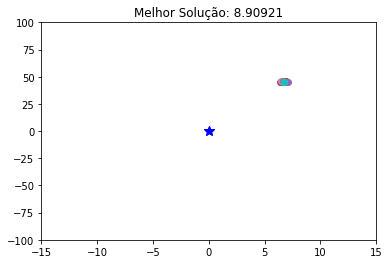

Iteração: 172


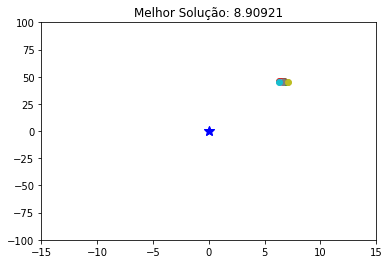

Iteração: 173


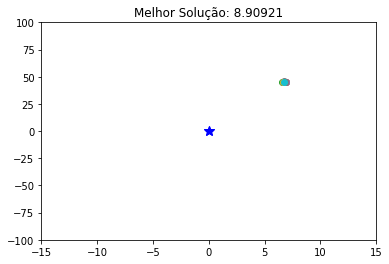

Iteração: 174


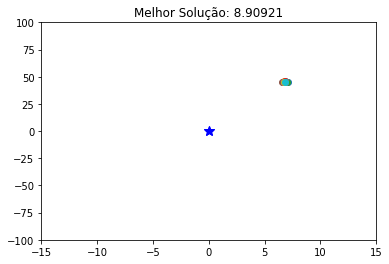

Iteração: 175


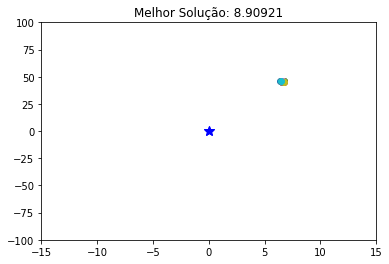

Iteração: 176


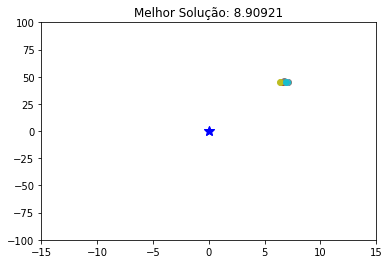

Iteração: 177


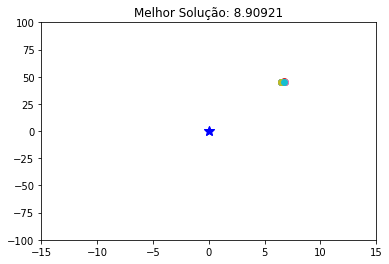

Iteração: 178


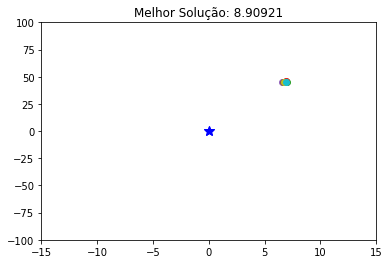

Iteração: 179


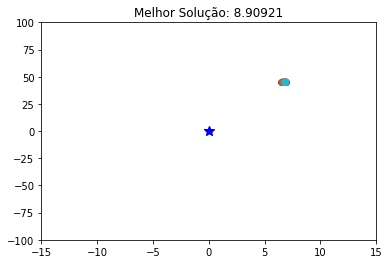

Iteração: 180


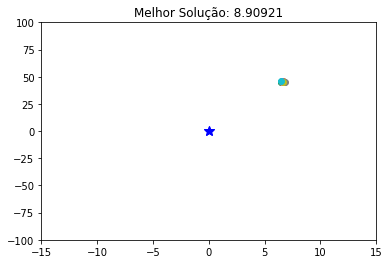

Iteração: 181


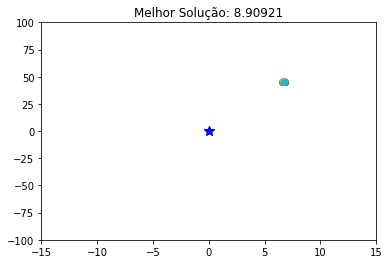

Iteração: 182


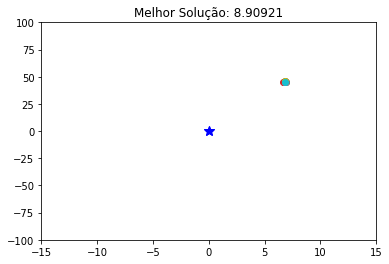

Iteração: 183


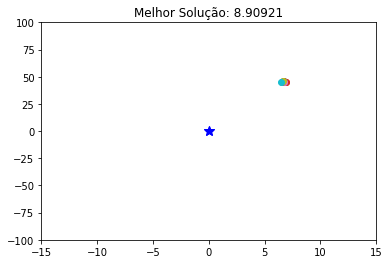

Iteração: 184


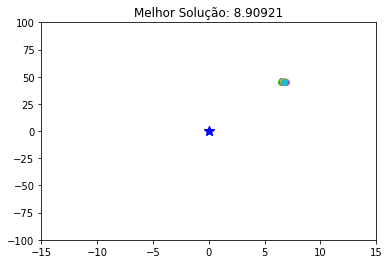

Iteração: 185


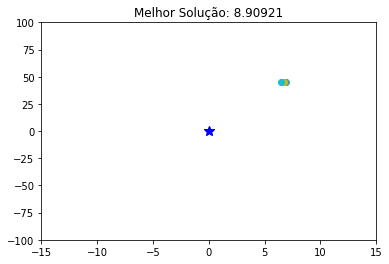

Iteração: 186


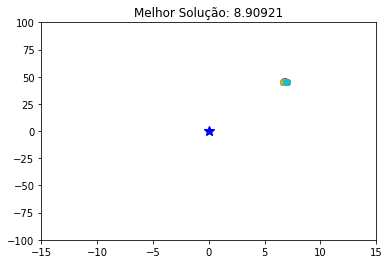

Iteração: 187


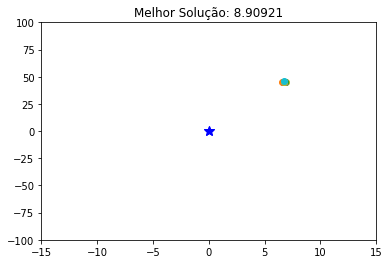

Iteração: 188


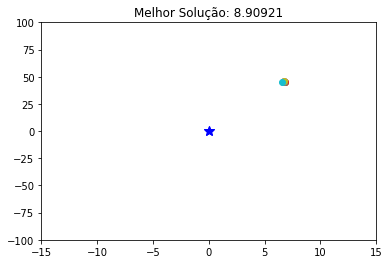

Iteração: 189


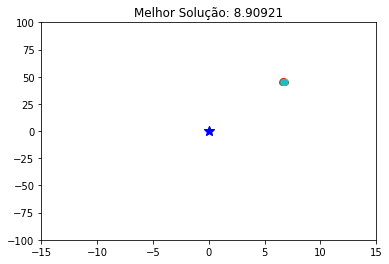

Iteração: 190


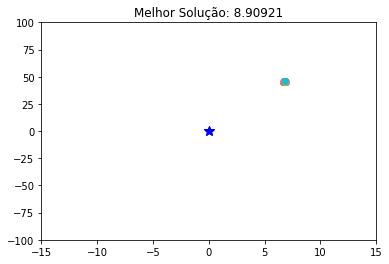

Iteração: 191


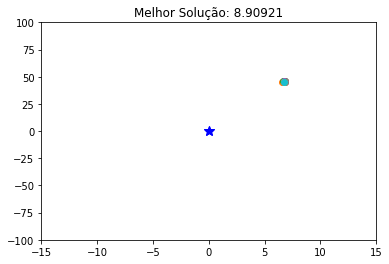

Iteração: 192


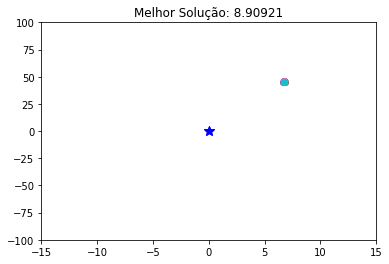

Iteração: 193


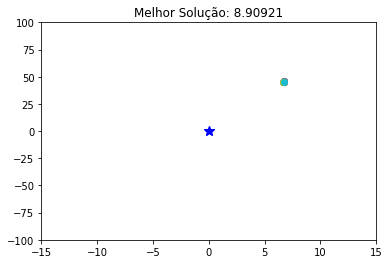

Iteração: 194


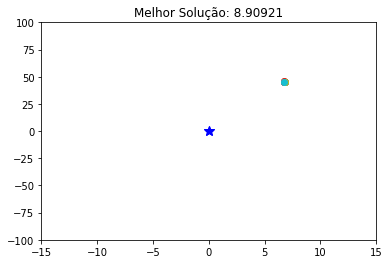

Iteração: 195


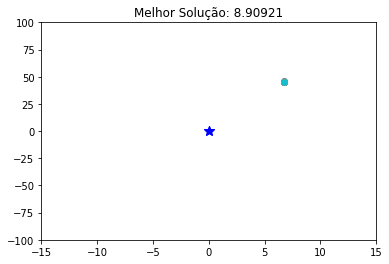

Iteração: 196


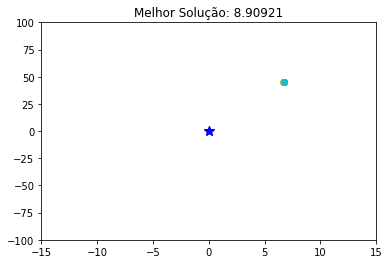

Iteração: 197


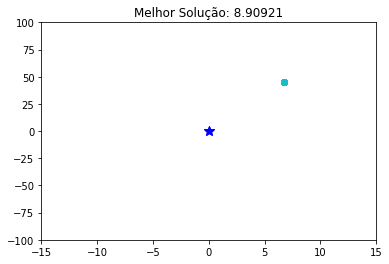

Iteração: 198


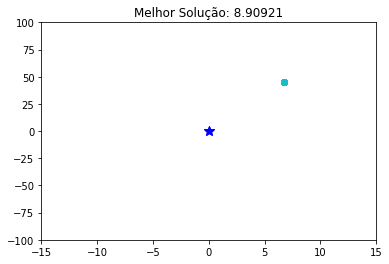

Iteração: 199


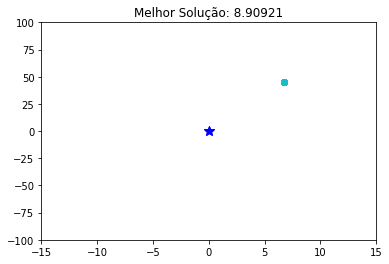

Iteração: 200


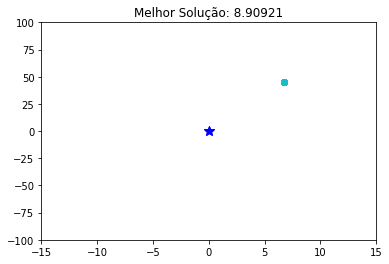

In [ ]:
#otimização FSS
passo = PASSO_INICIAL
melhor_fitness = 999999999999
fitness_tempo = []
populacao = PEIXES
convergencia = []
for i in range(ITERACOES):
  print("Iteração: {:.0f}".format(i+1))
  movimento_individual(populacao, passo, FCUSTO)
  mudanca_peso = alimentacao(populacao)
  movimento_instintivo(populacao)
  baricentro = calcular_baricentro(populacao)
  movimento_volitivo(populacao, baricentro, mudanca_peso, passo)
  passo = atualizar_passo(passo)
  plt.axis([E1,E2,E3,E4])
  plt.plot(0,0, marker='*', markersize=10, color='b')
  for i in range(CARDUME):
    populacao[i].fitness = fcusto(FCUSTO, populacao[i].posicao)
  for i in populacao:
    if melhor_fitness > i.fitness:
      melhor_fitness = i.fitness
  fitness_tempo.append(melhor_fitness)
  #exibe o enxame - mostrando no gráfico as posições atuais de cada paixe no aquário
  x = []
  y = []
  for i in range (CARDUME):
    p = populacao[i]
    d1,d2 = zip(p.posicao)
    x.append(d1)
    y.append(d2)
  exibe_grafico('Melhor Solução: {:.5f}'.format(melhor_fitness),x,y)
  convergencia.append(melhor_fitness)

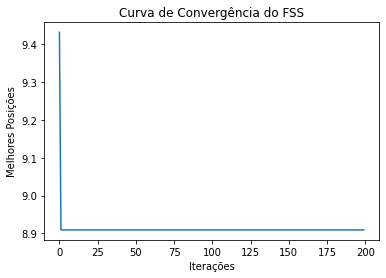

In [ ]:
#exibe curva de convergência dos peixes
x = []
y = []
for i in range(ITERACOES):
  x.append(i)
  y.append(convergencia[i])
plt.title("Curva de Convergência do FSS")
plt.xlabel("Iterações")
plt.ylabel("Melhores Posições")
plt.plot(x,y)
plt.show()
#for i in range(ITERACOES): print("iteração:",i,"posição:",convergencia[i])